# 14. RNN을 이용한 인코더-디코더

## 1) 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)

시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델입니다. 

예를 들어 챗봇(Chatbot)과 기계 번역(Machine Translation)이 그러한 대표적인 예인데, 입력 시퀀스와 출력 시퀀스를 각각 질문과 대답으로 구성하면 챗봇으로 만들 수 있고, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기로 만들 수 있습니다. 

### 1. 시퀀스-투-시퀀스(Sequence-to-Sequence)

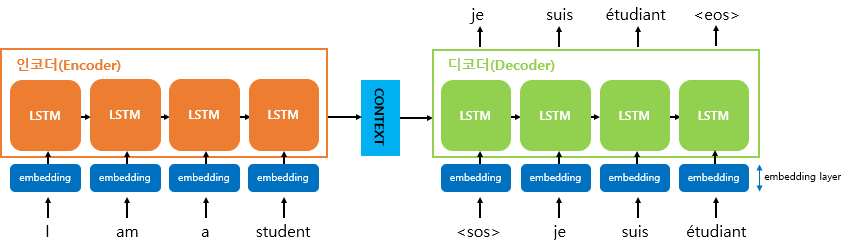

### 2. 문자 레벨 기계 번역기(Character-Level Neural Machine Translation) 구현하기

#### 1) 병렬 코퍼스 데이터에 대한 이해와 전처리

```
Watch me.           Regardez-moi !
```
여기서 사용할 fra.txt 데이터는 위와 같이 왼쪽의 영어 문장과 오른쪽의 프랑스어 문장 사이에 탭으로 구분되는 구조가 하나의 샘플입니다. 

In [1]:
import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
lines = pd.read_csv('datasets/fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 191954


In [3]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
35929,I'll come right now.,J'arrive tout de suite.
50688,She followed him home.,Elle le suivit à la maison.
57950,That's not my decision.,Ce n'est pas ma décision.
38649,We really need that.,Nous avons vraiment besoin de ça.
21270,Were you excited?,Étiez-vous excité ?
21001,Watch yourselves.,Prenez garde !
21653,You deserve this.,Tu mérites ça.
20182,The noes have it.,"Le ""non"" l'emporte."
13029,Close the hatch.,Fermez la trappe.
14653,Is it poisonous?,Est-ce toxique ?


번역 문장에 해당되는 프랑스어 데이터는 시작을 의미하는 심볼 <sos>과 종료를 의미하는 심볼 <eos>을 넣어주어야 합니다. 
    
여기서는 <sos>와 <eos> 대신 '\t'를 시작 심볼, '\n'을 종료 심볼로 간주하여 추가하고 다시 데이터를 출력해보겠습니다.

In [4]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
56567,I'm sick of hearing it.,\t J'en ai marre de l'entendre. \n
45739,Where are the others?,\t Où sont les autres ? \n
50827,Show me your passport.,\t Montrez-moi votre passeport ! \n
59708,Where's the toothpaste?,\t Où est le dentifrice ? \n
28306,Get out of my room.,\t Sors de ma chambre ! \n
4699,"Hey, wait up!","\t Hé, un moment ! \n"
32131,Tom seems dejected.,\t Tom semble abattu. \n
20031,That sounds fair.,\t Ça a l'air juste. \n
10523,I said nothing.,\t Je ne dis rien. \n
6507,Are you blind?,\t Êtes-vous aveugle ? \n


문자 집합을 생성해보겠습니다. 

In [5]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [6]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :', src_vocab_size)
print('target 문장의 char 집합 :', tar_vocab_size)

source 문장의 char 집합 : 79
target 문장의 char 집합 : 105


In [7]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print()
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


문자 집합에 문자 단위로 저장된 것을 확인할 수 있습니다.

각 문자에 인덱스를 부여하겠습니다.

In [8]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print()
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}

{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 

인코더의 입력이 될 영어 문장 샘플에 대해서 정수 인코딩을 수행합니다. 

In [9]:
encoder_input = []

for line in lines.src:
    encoded_line = []
    # 각 줄에서 1개의 char
    for char in line:
        # 각 char을 정수로 변환
        encoded_line.append(src_to_index[char])
    encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :\n', encoder_input[:5])

source 문장의 정수 인코딩 :
 [[30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10], [31, 58, 10]]


디코더의 입력이 될 프랑스어 데이터에 대해서 정수 인코딩을 수행해보겠습니다.

In [10]:
decoder_input = []

for line in lines.tar:
    encoded_line = []
    for char in line:
        encoded_line.append(tar_to_index[char])
    decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :\n', decoder_input[:5])

target 문장의 정수 인코딩 :
 [[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2]]


디코더의 예측값과 비교하기 위한 실제값에 대해서 정수 인코딩을 수행해보겠습니다.

이번에는 정수 인코딩 과정에서 모든 프랑스어 문장의 맨 앞에 붙어있는 '\t'를 제거하도록 합니다.

In [11]:
decoder_target = []

for line in lines.tar:
    timestep = 0
    encoded_line = []
    for char in line:
        if timestep > 0:
            encoded_line.append(tar_to_index[char])
        timestep = timestep + 1
    decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :\n', decoder_target[:5])

target 문장 레이블의 정수 인코딩 :
 [[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2]]


앞서 먼저 만들었던 디코더의 입력값에 해당되는 decoder_input 데이터와 비교하면 decoder_input에서는 모든 문장의 앞에 붙어있던 숫자 1이 decoder_target에서는 제거된 것을 볼 수 있습니다. '\t'가 인덱스가 1이므로 정상적으로 제거된 것입니다. 

In [12]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 23
target 문장의 최대 길이 : 76


영어 데이터는 영어 샘플들끼리, 프랑스어는 프랑스어 샘플들끼리 길이를 맞추어서 패딩합니다.

In [13]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

모든 값에 대해서 원-핫 인코딩을 수행합니다. 

문자 단위 번역기므로 워드 임베딩은 별도로 사용되지 않으며, 예측값과의 오차 측정에 사용되는 실제값뿐만 아니라 입력값도 원-핫 벡터를 사용하겠습니다.

In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

#### 2) 교사 강요(Teacher forcing)

이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 

이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.

#### 3) seq2seq 기계 번역기 훈련시키기

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

In [16]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달합니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [17]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

디코더는 인코더의 마지막 은닉 상태를 초기 은닉 상태로 사용합니다. 

위에서 initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다.

디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. 

In [18]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, 
          batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
750/750 [==============================] - 18s 16ms/step - loss: 0.7492 - val_loss: 0.6622
Epoch 2/40
750/750 [==============================] - 11s 15ms/step - loss: 0.4558 - val_loss: 0.5353
Epoch 3/40
750/750 [==============================] - 11s 15ms/step - loss: 0.3819 - val_loss: 0.4766
Epoch 4/40
750/750 [==============================] - 11s 15ms/step - loss: 0.3393 - val_loss: 0.4333
Epoch 5/40
750/750 [==============================] - 11s 15ms/step - loss: 0.3108 - val_loss: 0.4094
Epoch 6/40
750/750 [==============================] - 11s 15ms/step - loss: 0.2901 - val_loss: 0.3929
Epoch 7/40
750/750 [==============================] - 11s 15ms/step - loss: 0.2741 - val_loss: 0.3825
Epoch 8/40
750/750 [==============================] - 11s 15ms/step - loss: 0.2613 - val_loss: 0.3711
Epoch 9/40
750/750 [==============================] - 11s 15ms/step - loss: 0.2506 - val_loss: 0.3663
Epoch 10/40
750/750 [==============================] - 11s 15ms/step - loss: 0.241

#### 4) seq2seq 기계 번역기 동작시키기

앞서 seq2seq는 훈련할 때와 동작할 때의 방식이 다르다고 언급한 바 있습니다. 이번에는 입력한 문장에 대해서 기계 번역을 하도록 모델을 조정하고 동작시켜보도록 하겠습니다.

전체적인 번역 동작 단계를 정리하면 아래와 같습니다.
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 \<SOS\>에 해당하는 '\t'를 디코더로 보냅니다.
3. 디코더가 \<EOS\>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

우선 인코더를 정의합니다.

encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용하는 것입니다.

In [19]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

디코더를 설계해보겠습니다.

In [20]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, 
                                                 initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, 
                      outputs=[decoder_outputs] + decoder_states)

단어로부터 인덱스를 얻는 것이 아니라 인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 만듭니다.

In [21]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [22]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [23]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Hi.
정답 문장: Salut ! 
번역 문장: Salut. 
-----------------------------------
입력 문장: I see.
정답 문장: Aha. 
번역 문장: Je conduis. 
-----------------------------------
입력 문장: Hug me.
정답 문장: Serrez-moi dans vos bras ! 
번역 문장: Serrez-moi la viande. 
-----------------------------------
입력 문장: Help me.
정답 문장: Aidez-moi. 
번역 문장: Aide-moi ! 
-----------------------------------
입력 문장: I beg you.
정답 문장: Je vous en prie. 
번역 문장: Je vous en fice. 
